In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

The following cell sets up the molecule driver that will be used for this exercise.

In [2]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)

The following cell is used to set up the ElectronicStructureProblem() and hamiltonion for the molecule. To simplify the hamiltonian, the molecule's core has been frozen and negligible orbitals have been removed using by passing in FreezeCoreTransformer(freeze_core=True, remove_orbitals(3,4)) into the ElectronicStuctureProblem().

By experimenting with different combinations of orbitals, it was determined the removal of orbitals 3 and 4 yielded the most compact qubit circuit in the HarTreeFock initialization in the cells below.

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer

problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

The following cell reates the qubit_op object which is the transformation of the orginal Fermion Hamiltonian set up by the ElectronicStructureProblem() into the Qubit Hamiltonian using ParityMapper().

Of all the mapper_types, the ParityMapper resulted in the most compact qubit circuit in the HarTreeFock initialization.

Furthermore, two_qubit_reduction = True and z2symmetry_reduction in the QubitConverter() further reduced the circuit.

The print statements at the end of the cell display the differences in the structure between these two hamiltonians.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [1])

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

qubit_op = converter.convert(main_op, num_particles=num_particles)

print('Hamiltonion: \nNumber of Terms = %s, \nTerm_0 = '%len(main_op), main_op.to_list()[0], '\n')
print('Converted Qubit Hamiltonian: \nNumber of Terms = %s, \nTerm_0 = ' %len(qubit_op), qubit_op[0])

Hamiltonion: 
Number of Terms = 117, 
Term_0 =  ('+-I+-I', (0.01255792950204598+0j)) 

Converted Qubit Hamiltonian: 
Number of Terms = 100, 
Term_0 =  -0.2031660615055871 * IIII


The following cell prints out some molecular data for the untransformed and transformed ElectronicStructureProblem() to illustrate the effects of the transformation. It can be seen that that freeing the core and removing orbitals 3 and 4 reduced the number of particles and spin orbitals that the problem needs to consider.

In [5]:
# The fermionic operators are mapped to qubit operators
num_particles_untransformed = (problem.molecule_data.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals_untransformed = 2 * problem.molecule_data.num_molecular_orbitals
print('Untransformed Molecule Data:\nNumber of particles = %i'%sum(num_particles_untransformed), '\nNumber of spin orbitals = %i\n' %num_spin_orbitals_untransformed)

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
print('Transformed Molecule Data:\nNumber of particles = %i'%sum(num_particles), '\nNumber of spin orbitals = %i' %num_spin_orbitals)

Untransformed Molecule Data:
Number of particles = 3 
Number of spin orbitals = 12

Transformed Molecule Data:
Number of particles = 2 
Number of spin orbitals = 6


The following cell sets up the HartTreeFock solver. This is a good checkpoint to see how much the circuit has been reduced by applying FreezeCoreTransformer(), remove_orbitals, two_qubit_reduction and z2symmetry_reduction.

In [6]:
from qiskit_nature.circuit.library import HartreeFock

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


The following cell diagonalizes the converted hamiltonion to provide the exact classical solution of the ground state energy of the molecule. This is the grouth truth value that the VQE will be checked against.

In [7]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
# print(result_exact)

Exact electronic energy -1.0887060157347377


The following cell selects the optimizer that will be used for the classical parameter tuning part of the VQE algorithm.

In [8]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

The following cell sets up the ansatz for the quantum eigensolver part of the VQE algorithm. The cell provides code for a TwoLocal, PUCCD, UCCSD, SUCCD and Custom ansatz. The problem was solved and optimized to a circuit with 4 parameters and 3 CNOT gates using a TwoLocal ansatz with the rotation blocks and entangler maps shown below.

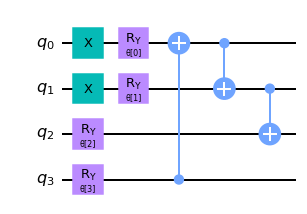

In [9]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
# Choose the ansatz
ansatz_type = "TwoLocal"

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entangler_map = [(3, 0), (0, 1), (1, 2)]
    entanglement = entangler_map
    #entanglement = 'circular'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
    
# print(ansatz)
ansatz.draw(output='mpl')

The following cell sets up and performs the VQE algorithm. It outputs the VQE's calculated minimum eigenvalue (ground state energy) and assocaited eigenstate. This value is compared to the exact electronic energy calculated from the classical diagonalizer above to calcaulte the chemical accuracy.

In [14]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
percent_accuracy = 100-np.abs(100*(result.eigenvalue-exact_energy)/exact_energy)
nominal_accuracy = result.eigenvalue-exact_energy

print('Exact Electronic Energy = %f' %exact_energy)
print('Minimum Eigenvalue = %f' %result.eigenvalue)
print('Nominal Chemical Accuracy = {:.6f}'.format(nominal_accuracy), 'mHa')
print('Percent Chemical Accuracy = {:.3f}'.format(percent_accuracy), '%')
print('Minimum Eigenstate = %s' %result.eigenstate)
print('Optimal Point = %s' %result.optimal_point)

Exact Electronic Energy = -1.088706
Minimum Eigenvalue = -1.086193
Nominal Chemical Accuracy = 0.002513 mHa
Percent Chemical Accuracy = 99.769 %
Minimum Eigenstate = [-1.04032427e-03+1.27402979e-19j  6.73735243e-06-1.49599276e-21j
  1.76714566e-05+7.76243880e-38j -9.92054292e-01+3.41771915e-16j
 -5.20287781e-02+6.37168766e-18j  3.36948993e-04-7.48177060e-20j
  3.53343781e-07+1.55211284e-39j -1.98362943e-02+6.83378757e-18j
  2.25215483e-03-7.75888251e-19j -4.01176194e-08-1.76222352e-40j
 -3.82562030e-05+8.49458349e-21j  5.90719528e-03-7.23422779e-19j
  1.12634942e-01-3.88037835e-17j -2.00636549e-06-8.81324595e-39j
 -7.64939288e-07+1.69850642e-22j  1.18115374e-04-1.44649615e-20j]
Optimal Point = [-0.10479498  3.14091336  3.10160764 -0.22610592]


The cell below takes the results obtained and displays relevent data and statistics as well as a plot of the calculated minimum eigenvalue at each VQE iteration to visualize the convergene properties for this problem.

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,4,NaN,NaN,NaN,NaN,2.513310,True,3
1,COBYLA,TwoLocal,4,4,NaN,NaN,NaN,NaN,2.513321,True,3
2,COBYLA,TwoLocal,4,4,NaN,NaN,NaN,NaN,2.513321,True,3
3,COBYLA,TwoLocal,4,4,NaN,NaN,NaN,NaN,2.513312,True,3
0,COBYLA,TwoLocal,4,4,None,None,None,None,2.513310,True,3


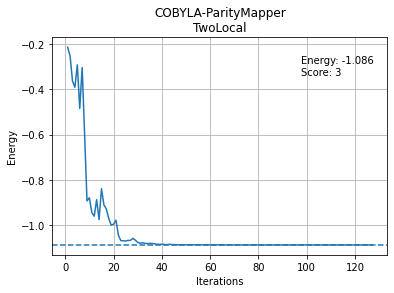

In [11]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "Custom":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

The following cell can be used to check the answer against an IBM IQC2021 ex5 grader. Note that since the core is frozen, the calculated ground state energy only considers the active orbitals and the grader file needs to account for this so freeze_core = True must be set.

In [12]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

